In [ ]:
from traitlets.config import Any
from __future__ import annotations

from typing import Iterable
from typing import Callable
from typing import List
from dataclasses import dataclass
from abc import ABC, abstractmethod

import itertools
import functools
import pickle
import numbers
from math import prod

import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import parse_version
import webcolors

neg_inf = -float('inf')
pos_inf = float('inf')

class Fuzzy:

  @dataclass
  class Rule_Set:
    # all rules should share conseqent domain
    r_list: dict[str, Fuzzy.Rule]
    ant_groups: dict[str, list[Fuzzy.Rule.Ant]]
    label: str
    '''
    agg: sum, max, min
    rule_type: and_chain, list
    member_func:
    '''

    def __init__(self, rl: dict[str, Fuzzy.Rule], label:str, a:str):
      self.r_list = rl
      self.label = label
      self.agg = self.set_agg(a)

    def plot(self):
      print("PRINTING SET OF RULES")
      j = 1
      for i in self.r_list:
        r = self.r_list[i]
        print(f"Rule label: {r.label} Rule enum: {j}")
        r.plot()
        j += 1
      print("END")

    def plot_ant_groups(self):
      colors = plt.cm.tab10.colors
      for key in self.ant_groups:
        agroup = self.ant_groups[key]
        reduced_colors = colors[:len(agroup)]
        plt.figure(figsize=(8, 5))
        plt.ylabel('Fuzzy membership')
        plt.xlabel('The domain of interest')
        plt.ylim(-0.1, 1.1)
        plt.title(f"Combined antecedents for each class, FEATURE:{agroup[0].label} MF:{agroup[0].ant_type}" )
        k = next(i for i in self.r_list)
        if self.r_list[k].con.cat is not None:
          space= 0
          for i in zip(agroup, reduced_colors,self.r_list[k].con.cat):
            plt.plot(i[0].domain, i[0].f_set, 'k')
            plt.fill_between(i[0].domain, i[0].f_set, color=i[1],alpha=0.4)
            plt.text(x = 9, y=space, s=f'{i[2]}', color=i[1], fontsize=12,va='center', ha='center')
            space += .05
          plt.show()
        else:
          for i in zip(agroup, reduced_colors):
            plt.plot(i[0].domain, i[0].f_set, 'k')
            plt.fill_between(i[0].domain, i[0].f_set, color=i[1],alpha=0.4)
          plt.show()


    def set_agg(self, agg):
      match agg:
        case "sum":
          return sum
        case "max":
          return max
        case "prod":
          return prod
        case _:
          return sum

  class Rule:
    label: str
    ant: list[Ant]
    con: Con

    def __init__(self, a:list[Ant], c:Con, label:str):
      self.label = label
      self.ant = a
      self.con = c

    def fire_rule(self, x:dict[Hashable, Any]):
      min_val = 1.0
      for a in self.ant:
        val = a.eval_ant(x[a.label])
        min_val = min(min_val, val)
      return self.con.eval_consq(min_val)

    def plot(self):
      print("ANTECEDENTS")
      for a in self.ant:
        a.plot()
      print("CONSEQEUNCE")
      self.con.plot()

    class Ant(ABC):
      label: str
      ant_type: str
      domain: list[float]
      f_set: list[float]
      cat: list[str]
      additional_info:str

      @abstractmethod
      def eval_ant(self, x:float) -> float:
        pass

      def plot(self):
        plt.figure(figsize=(8, 5))
        plt.plot(self.domain, self.f_set, 'k')
        # plt.fill_between(self.domain, self.f_set, color="skyblue",alpha=0.4)
        plt.ylabel('Fuzzy membership')
        plt.xlabel('The domain of interest')
        plt.title(f"{self.additional_info} {self.label} {self.ant_type}" )
        plt.ylim(-0.1, 1.1)
        plt.show()

    class D_Ant(Ant):
      ant_list = list[float]()

      def __init__(self, d_set: list[float], domain: list[float], label: str,
                   t: str, cat:list[str] = [], additional_info=''):
        self.label = label
        self.ant_type = t
        self.f_set = d_set.copy()
        self.domain = domain
        self.additional_info = additional_info

      def eval_ant(self, x: float) -> float:
        return self.f_set[int(x)]

    class C_Ant(Ant):
      def __init__(self, crit_points: list[float], domain: list[float], label: str,
                   t: str, func, cat:list[str] = [], additional_info=''):
        self.label = label
        self.ant_type = t
        self.crit_points = crit_points
        self.func = func
        self.domain = domain
        self.f_set = list[float]()
        self.additional_info = additional_info

        for i in self.domain:
          val = self.func(i, self.crit_points)
          if val < 0:
            val = 0
          if val > 1:
            val = 1
          self.f_set.append(val)

      def eval_ant(self, x:float) -> float:
        return self.func(x, self.crit_points)

    class Con(ABC):
      label:str
      con_type: str
      domain: list[float]
      f_set: list[float]
      cat: list[str] = None
      additional_info:str
      correlation_scalar:float

      @abstractmethod
      def eval_consq(self, x:float) -> list[float]:
        pass

      def plot(self):
        if self.con_type == "singleton":
          plt.bar(self.cat, self.f_set)
          plt.title(f"{self.label} {self.con_type}")
          plt.xlabel('Categories')
          plt.ylabel('Values')
          plt.show()
        else:
          plt.figure(figsize=(8, 5))
          plt.plot(self.domain, self.f_set, 'k')
          # plt.fill_between(self.domain, self.f_set, color="skyblue",alpha=0.4)
          plt.ylabel('Fuzzy membership')
          plt.xlabel('The domain of interest')
          plt.title(f"{self.additional_info} {self.label} {self.con_type}" )
          plt.ylim(-0.1, 1.1)
          plt.show()

    class D_Con(Con):
      '''
      domain should be a list of discrete points
      '''
      def __init__(self, d_set: list[float], domain: list[float], label:str,
                   t: str,cat:list[str] = []):
        self.label = label
        self.con_type = t
        self.f_set = d_set.copy()
        self.domain = domain
        self.cat = cat

      def eval_consq(self, x: float) -> list[float]:
        copy = self.f_set.copy()
        for i in range(len(copy)):
          copy[i] = min(x, copy[i])
        return copy

    class C_Con(Con):
      '''
      Domain should be a closed interval
      '''
      def __init__(self, c: list[float], domain: list[float], label:str,
                   t:str, func, cat:list[str] = [], additional_info:str='',
                   c_scalar: float=0):
        self.label = label
        self.con_type = t
        self.crit_points = c
        self.func = func
        self.domain = domain
        self.f_set = list[float]()
        self.cat = cat
        self.additional_info = additional_info
        self.correlation_scalar = c_scalar

        if t == "gauss":
          self.f_set = self.func(self.domain, self.crit_points)
        else:
          for i in self.domain:
            val = self.func(i, self.crit_points)
            if val < 0:
              val = 0
            if val > 1:
              val = 1
            self.f_set.append(val)


      def eval_consq(self, x: float) -> list[float]:
        fuzzy_set = list[float]()
        for i in self.f_set:
          val = min(i, x)
          if val < 0:
            val = 0
          fuzzy_set.append(val)
        return fuzzy_set

  '''
  Engine type -- 0 is for mandami
  rule_file -- serialized picklefile
  A rule set is a group that fires at once
  A list of rules indicates multiple outputs
  '''
  rule_sets = dict[str, Rule_Set]()

  def __init__(self, Engine_type: int=0, rule_file: str=""):
    if rule_file != "":
      self.load_rule_set(rule_file)

  def save_rule_set(self, file_name:str):
    with open(file_name, 'wb') as f:
      pickle.dump(self.rule_sets, f)

  def load_rule_set(self, file_name:str):
    with open(file_name, 'rb') as f:
      self.rule_sets = pickle.load(f)

  '''
  input is a dictionary
  ants pull the data they want based on their label
  '''
  def fire_all_sets(self, inputs: dict[Hashable, Any]) -> list[float]:
    results = list[float]()
    for key in self.rule_sets:
      rule_set = self.rule_sets[key]
      fuzzy_sets = list[list[float]]()
      rule: Fuzzy.Rule
      for key in rule_set.r_list:
        rule = rule_set.r_list[key]
        new_set = rule.fire_rule(inputs)
        fuzzy_sets.append(new_set)
      defuzz = self.defuzz(fuzzy_sets, rule, rule_set)
      results.append(defuzz)
    return results

  def fire_one_set(self, inputs: dict[Hashable, Any], key) -> float:
    results = list[float]()
    rule_set = self.rule_sets[key]
    fuzzy_sets = list[list[float]]()
    rule: Fuzzy.Rule
    for key in rule_set.r_list:
      rule = rule_set.r_list[key]
      new_set = rule.fire_rule(inputs)
      # self.fuzzy_plot(new_set, rule.con.domain, f'con {rule.con.label} after firing')
      fuzzy_sets.append(new_set)
    defuzz = self.defuzz(fuzzy_sets, rule, rule_set)
    return defuzz

  def defuzz(self, rule_results: List[List[float]], r: Rule, r_set: Rule_Set) -> float:
    num = 0
    den = 0
    aggregated_rules = list[float]()
    for i in zip(*rule_results):  # zip up con f-sets to aggregate
      aggregated_rules.append(r_set.agg(i))
    for i in aggregated_rules:
      if i < 0:
        raise ValueError(f"Negative membership in rule")
    #self.fuzzy_plot(aggregated_rules, r.con.domain, f"Aggregated results {r_set.agg} for {r.con.label}")
    if r.con.con_type == 'singleton':
      return aggregated_rules.index(max(aggregated_rules))
    else:
      num += sum(i * val for i, val in zip(r.con.domain, aggregated_rules))
      den += sum(aggregated_rules)
      try:
        #print(num / den)
        return num / den  # Division by zero
      except ZeroDivisionError:
        return 0

  @staticmethod
  def mf_trap(point: float, crit_points: list[float]):
    if len(crit_points) == 4:
      if crit_points[0] <= point < crit_points[1]:
        return (point - crit_points[0]) / (crit_points[1] - crit_points[0])
      elif crit_points[1] <= point < crit_points[2]:
        return 1
      elif crit_points[2] <= point < crit_points[3]:
        return (crit_points[3] - point) / (crit_points[3] - crit_points[2])
      else:
        return 0.0
    elif crit_points[0] == neg_inf:
      if point <= crit_points[1]:
        return 1.0
      else:
        return (crit_points[2] - point) / (crit_points[2] - crit_points[1])
    else:
      if point >= crit_points[2]:
        return 1.0
      else:
        return (point - crit_points[0]) / (crit_points[1] - crit_points[0])

  @staticmethod
  def mf_tri(point: float, crit_points: list[float]) -> float:
    if len(crit_points) != 3:
      raise ValueError("Crit_points for mf_tri needs to be 3 points")
    if crit_points[0] <= point < crit_points[1]:
      return (point - crit_points[0]) / (crit_points[1] - crit_points[0])
    elif crit_points[1] <= point < crit_points[2]:
      return (crit_points[2] - point) / (crit_points[2] - crit_points[1])
    else:
      return 0.0

  @staticmethod
  def mf_gauss(point: list[float], crit_points: list[float]):
    mean = crit_points[0]
    std = crit_points[1]
    return norm.pdf(point, mean, std) / norm.pdf(mean, mean, std)

  def mf_singleton(point: float, crit_points: list[float]):
    return 1.0

  def plot_r_sets(self):
    for key in self.rule_sets:
      r_set = self.rule_sets[key]
      r_set.plot()


  def rule_plot(self, r_set_label:str, rule_label:str):
    r_set = self.rule_sets[r_set_label]
    rule = r_set.r_list[rule_label]
    for ant in rule.ant:
      self.standard_plot(rule, ant)
    con = rule.con
    self.standard_plot(rule, con=con)


  def standard_plot(self, rule: Rule, ant=None, con=None):
    if ant is not None:
      plt.figure(figsize=(8, 5))
      plt.plot(ant.domain, ant.f_set, 'k')
      plt.fill_between(ant.domain, ant.f_set, color="skyblue",alpha=0.4)
      plt.ylabel('Fuzzy membership')
      plt.xlabel('The domain of interest')
      plt.title(f"Rule: {rule.label} / Ant: {ant.label}")
      plt.ylim(-0.1, 1.1)
      plt.show()
    elif con is not None:
      plt.figure(figsize=(8, 5))
      plt.plot(con.domain, con.f_set, 'k')
      plt.fill_between(con.domain, con.f_set, color="skyblue",alpha=0.4)
      plt.ylabel('Fuzzy membership')
      plt.xlabel('The domain of interest')
      plt.title(f"Rule: {rule.label} / Con: {con.label}")
      plt.ylim(-0.1, 1.1)
      plt.show()
    else:
      pass

  @staticmethod
  def fuzzy_plot(f_set: list[float], d_set: list[float], title: str):
    plt.figure(figsize=(8, 5))
    plt.plot(d_set, f_set, 'k')
    plt.fill_between(d_set, f_set, color="skyblue",alpha=0.4)
    plt.ylabel('Fuzzy membership')
    plt.xlabel('The domain of interest')
    plt.title(title)
    plt.ylim(-0.1, 1.1)
    plt.show()

  @staticmethod
  def discrete_plot(cat: list[str], val: list[float], title:str):
    plt.bar(cat, val)
    plt.title(title)
    plt.xlabel('Categories')
    plt.ylabel('Values')
    plt.show()

  def multi_plot(self):
    pass

  tri_1 = {
      'func' : mf_tri,
      'label' : "tri_std",
      'crit_points' : ['std', 'mean', 'std'],
      'scalar' : [-2 , 1, 2]
  }

  tri_2 = {
      'func' : mf_tri,
      'label' : 'tri_minmax',
      'crit_points' : ['min', 'mean', 'max'],
      'scalar' : [1, 1,  1]
  }

  trap_1 = {
      'func' : mf_trap,
      'label' : 'trap_std',
      'crit_points' : ['std', 'std', 'std', 'std'],
      'scalar' : [-2, -1, 1, 2]
  }

  trap_2 = {
      'func' : mf_trap,
      'label' : 'trap_box',
      'crit_points' : ['min', '25%', '75%', 'max'],
      'scalar' : [1, 1, 1, 1]
  }

  gauss_1 = {
      'func' : mf_gauss,
      'label' : 'gauss',
      'crit_points' : ['mean', 'std'],
      'scalar' : [1, 1]
  }

  gauss_2 = {
      'func' : mf_gauss,
      'label' : 'gauss_diminished',
      'crit_points' : ['mean', 'std'],
      'scalar' : [1, .75]
  }

  singleton = {
      'func' : mf_singleton,
      'label' : "singleton",
      'crit_points' : [1],
      'scalar' : [1]
  }

  mf_type_list = {'tri_1':tri_1, 'tri_2':tri_2, 'trap_1':trap_1, 'trap_2':trap_2,
                  'gauss_1':gauss_1, 'gauss_2':gauss_2}

  # these initializers need to be more generic, the feature dict shouldnt be
  # domain specific
  # step_size added
  @staticmethod
  def init_ant(mf_str: str, feature: dict):
    mf = Fuzzy.mf_type_list[mf_str]
    crit_points = []
    mf_crit = mf["crit_points"]
    scalars = mf["scalar"]
    step_size = (feature['global_domain_max'] - feature['global_domain_min']) * 100
    domain = list(np.linspace(feature['global_domain_min'], feature['global_domain_max'], int(step_size)))

    for i in range(len(mf_crit)):
      if mf_crit[i] == 'std' and mf['label'] != 'gauss' and mf['label'] != 'gauss_diminished':  # spagetti code here
        # print(feature['mean'] + scalars[i] * feature[mf_crit[i]])
        crit_points.append(feature['mean'] + scalars[i] * feature[mf_crit[i]] + scalars[i] * .001)
      elif mf_crit[i] == 'min':
        crit_points.append(scalars[i] * feature[mf_crit[i]] - scalars[i] *  .001)
      elif mf_crit[i] == 'max':
        crit_points.append(scalars[i] * feature[mf_crit[i]] - scalars[i] * .001)
      else:
        crit_points.append(scalars[i] * feature[mf_crit[i]])

    ant = Fuzzy.Rule.C_Ant(t=f"{mf['label']}",
                          label=f"{feature['feature']}",
                          additional_info=f"{feature['species']}",
                          # add additional info for printing...
                           # f"{feature['species']}:{feature['feature']}" this messes up rule fire
                          c=crit_points,
                          domain=domain,
                          func = mf['func'])
    return ant

  @staticmethod
  def init_con(mf_str: str, feature: dict):  # type is "class", "reg"
    if mf_str == "singleton":
      l = feature['distinct_species']
      index = l.index(feature['species'])
      f_set = list[float]()
      for i in range(len(feature['distinct_species'])):
        if i == index:
          f_set.append(1.0)
        else:
          f_set.append(0.0)
      con = Fuzzy.Rule.D_Con(f_set, range(len(feature['distinct_species'])),
                             label=f'{feature["species"]}',
                             t=f"singleton", cat=l)
    else:
      pass
    return con

  @staticmethod
  def confusion_matrix(r_set: Rule_set, actual:list[Any], predicted:list[Any], labels:list[Any]):
    cm = confusion_matrix(actual, predicted, labels=labels)
    correct = 0
    wrong = 0
    for i in range(len(labels)):
      for j in range(len(labels)):
        if i != j:
          wrong += cm[i][j]
        else:
          correct += cm[i][j]
    average = correct / (correct + wrong)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
    plt.title(r_set.label)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.text(x=1.5, y=3.5, s=f'Average Accuracy: {average:.2f}', fontsize=12,va='center', ha='center')
    plt.show()







# todo: test everything
# make functions to print rules, and aggregations
# that should be an abstract function in rule class







['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
[0.1878887507189199, 0.04306199845160533, 0.5864501344746885, 0.4414817585625709, 0.21202248101455073, 0.17405358696874265, -0.3947892506709185, 0.4304528847447728, 0.5658825924427437, 0.38248348424858103]
['sum', 'max']
Rules with sum aggregation
[167.3390568000046, 97.55659700332052, 161.1814843416911, 146.96975119858254, 114.43453975536738, 108.68602430055664, 106.12804879885907, 148.90463649088358, 163.72723352045801, 176.80055374159272, 113.94888257534346, 169.18018247361562, 107.55174331480004, 153.128812615301, 111.04204588564936, 184.9669695650962, 170.91226620411854, 177.01349041212498, 141.9173641237613, 118.16903169602567, 110.10239131156878, 107.92305096635192, 112.89696195133645, 198.67564721263355, 145.05910432216035, 141.5064614857884, 112.03088658807023, 157.77566031389202, 115.676119441598, 151.43955208016493, 138.7451706784938, 97.6189139437325, 168.1317018631874, 120.64364638450745, 89.9516446363335, 111

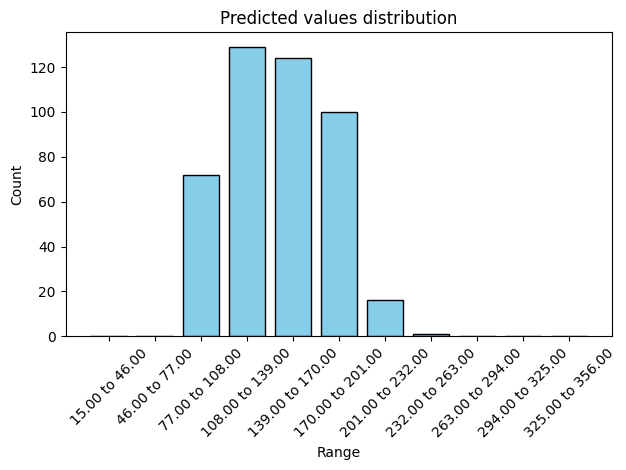

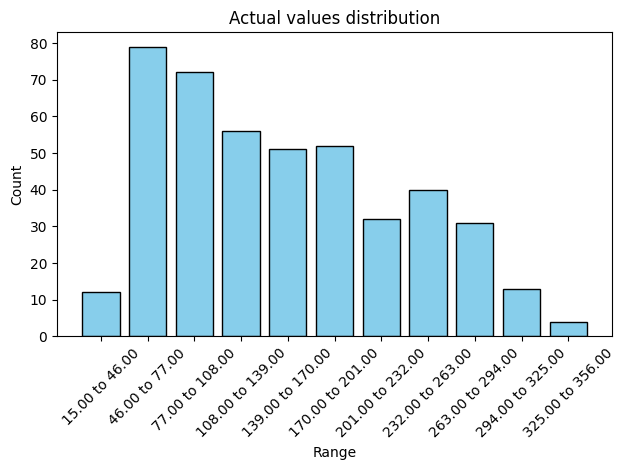

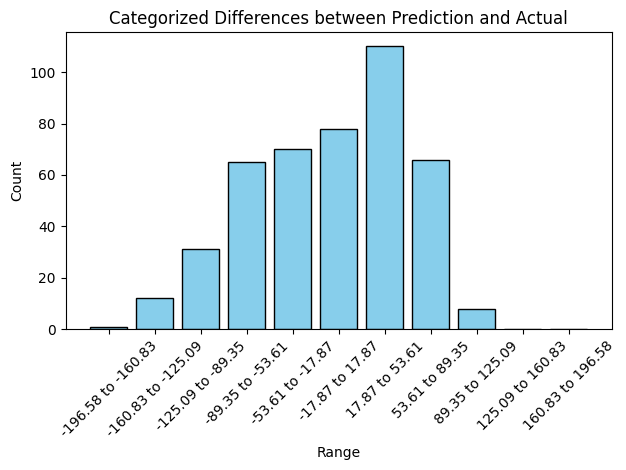

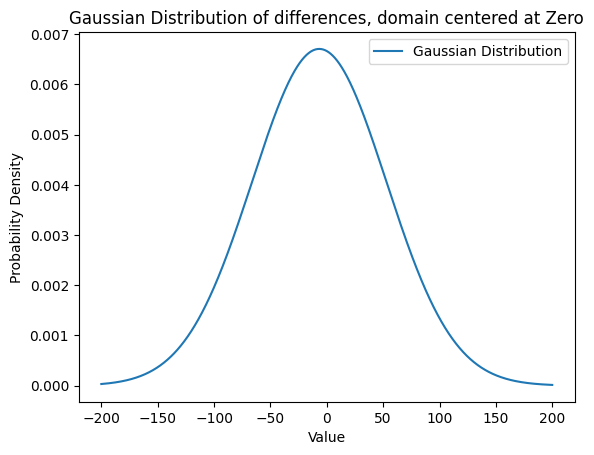

Rules with max aggregation
[166.00396134087532, 101.77210783405154, 157.35967867518235, 145.64535076115664, 112.8873503825794, 107.81116112308543, 111.16719133062463, 149.62211520010584, 157.90328749323066, 179.510042752117, 114.82492876479824, 167.6651512211201, 111.64045704911558, 152.5951295118881, 116.2916206901809, 181.83626106324982, 171.86398464774845, 177.85299419403225, 137.513841222528, 112.70049615593308, 110.83966985711218, 109.25771163320735, 114.4592350653583, 198.70270771499062, 149.69404391883023, 139.8163886000275, 113.22066062316938, 163.99827090287616, 116.11165762259863, 162.13316749459688, 141.99001213882596, 101.4536737462858, 165.1525588856332, 118.4263168853465, 90.00964612669674, 116.4134200623839, 169.69629791037264, 149.77650856250187, 198.39794520656116, 158.62684540896618, 166.8652742688388, 101.29377301026402, 140.6232491848524, 98.68666232518311, 180.51551064347714, 120.29178731735934, 124.40320311761143, 106.67661535473174, 111.2574616373863, 174.6542903

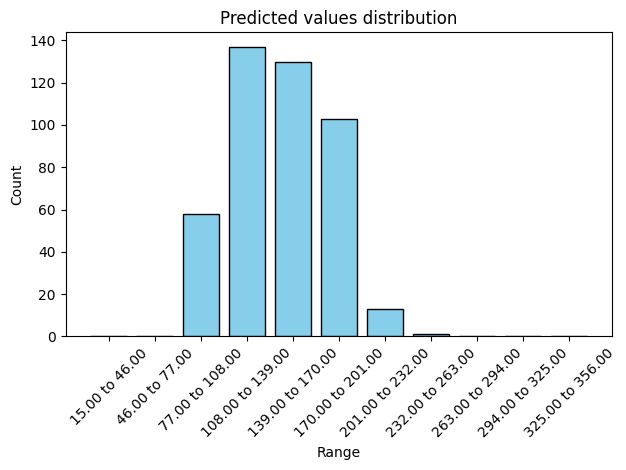

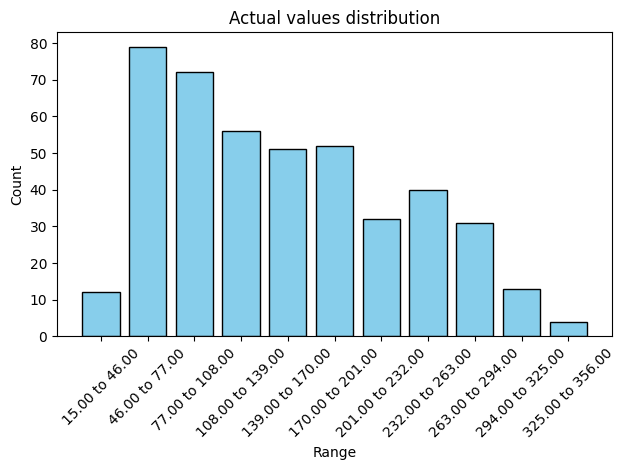

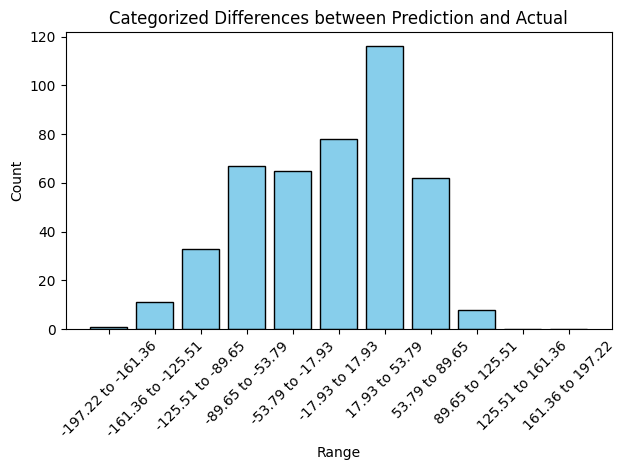

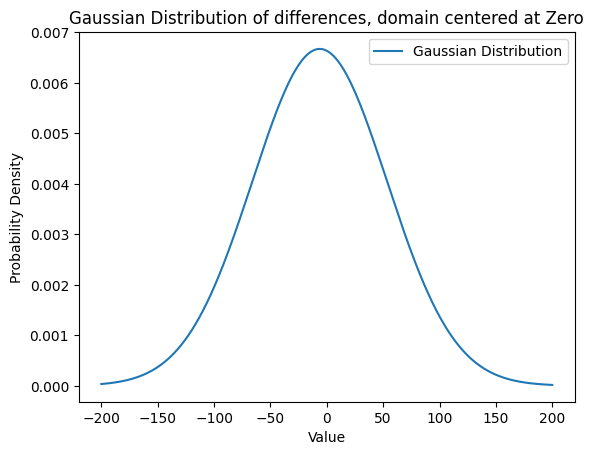

In [ ]:
from scipy.stats.distributions import anglit_gen
# diabetes
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression

def plot_suite(predictions: list[float], actual:list[float]):
  number_of_ranges = 11
  max_both = max(*predictions, *actual) + 10
  min_both = min(*predictions, *actual) - 10
  both_step = (max_both - min_both) / number_of_ranges
  print(min_both)
  print(max_both)
  both_range_edges = np.arange(min_both, max_both + both_step, both_step)
  categories = {}
  for i in range(len(both_range_edges) - 1):
      label = f"{both_range_edges[i]:.2f} to {both_range_edges[i+1]:.2f}"
      categories[label] = ((predictions > both_range_edges[i]) & (predictions <= both_range_edges[i+1])).sum()
  category_names = list(categories.keys())
  counts = list(categories.values())
  category_names = list(categories.keys())
  counts = list(categories.values())
  plt.bar(category_names, counts, color='skyblue', edgecolor='black')
  plt.title('Predicted values distribution')
  plt.xlabel('Range')
  plt.ylabel('Count')
  plt.xticks(rotation=45)  # Rotate category labels to fit them nicely
  plt.axhline(0, color='grey', linewidth=0.5)  # Add a line at zero count for reference
  plt.tight_layout()  # Adjust the plot to make sure everything fits without overlapping
  plt.show()

  categories = {}
  for i in range(len(both_range_edges) - 1):
      label = f"{both_range_edges[i]:.2f} to {both_range_edges[i+1]:.2f}"
      categories[label] = ((actual > both_range_edges[i]) & (actual <= both_range_edges[i+1])).sum()
  category_names = list(categories.keys())
  counts = list(categories.values())
  category_names = list(categories.keys())
  counts = list(categories.values())
  plt.bar(category_names, counts, color='skyblue', edgecolor='black')
  plt.title('Actual values distribution')
  plt.xlabel('Range')
  plt.ylabel('Count')
  plt.xticks(rotation=45)  # Rotate category labels to fit them nicely
  plt.axhline(0, color='grey', linewidth=0.5)  # Add a line at zero count for reference
  plt.tight_layout()  # Adjust the plot to make sure everything fits without overlapping
  plt.show()

  difference = np.array([a - b for a, b in zip(predictions, actual)])

  max_abs_diff = np.max(np.abs(difference))
  range_step = (max_abs_diff * 2) / (number_of_ranges)
  range_edges = np.arange(-max_abs_diff, max_abs_diff + range_step, range_step)
  categories = {}
  for i in range(len(range_edges) - 1):
      label = f"{range_edges[i]:.2f} to {range_edges[i+1]:.2f}"
      categories[label] = ((difference > range_edges[i]) & (difference <= range_edges[i+1])).sum()
  category_names = list(categories.keys())
  counts = list(categories.values())
  plt.bar(category_names, counts, color='skyblue', edgecolor='black')
  plt.title('Categorized Differences between Prediction and Actual')
  plt.xlabel('Range')
  plt.ylabel('Count')
  plt.xticks(rotation=45)  # Rotate category labels to fit them nicely
  plt.axhline(0, color='grey', linewidth=0.5)  # Add a line at zero count for reference
  plt.tight_layout()  # Adjust the plot to make sure everything fits without overlapping
  plt.show()

  std = np.std(difference)
  mean = np.mean(difference)
  min_val = -200
  max_val = 200
  domain = np.linspace(min_val, max_val, 2000)
  pdf = norm.pdf(domain, mean, std)
  plt.plot(domain, pdf, label='Gaussian Distribution')
  plt.xlabel('Value')
  plt.ylabel('Probability Density')
  plt.title('Gaussian Distribution of differences, domain centered at Zero')
  plt.legend()
  plt.show()

diab = load_diabetes()
X = diab.data
y = diab.target
feature_names = diab.feature_names
data = pd.DataFrame(data=diab.data, columns=diab.feature_names)
data['Progression'] = diab.target

correlations = []
for i in range(X.shape[1]):
  corr = np.corrcoef(X[:,i], y)[0,1]
  correlations.append(corr)

print(feature_names)
print(correlations)

persons_data = []
for i in range(X.shape[0]):
    person_dict = {feature_names[j]: X[i, j] for j in range(X.shape[1])}
    person_dict['target'] = y[i]
    persons_data.append(person_dict)

for person in persons_data:
  if person['sex'] < 0:
    person['sex'] = 0
  else:
    person['sex'] = 1

# homogenize, and only use traps
# sex is binary, skip for now

con_domain = list(np.linspace(0, 400, 401))

rule_list = []
ling_var = ["very low", "low", "low medium", "high medium", "high", "very high"]
ling_var = ["very low", "medium low", "low", "low medium", "medium medium",
            "high medium", "low high", "high", "very high"]
ling_var = ["low", "medium", "high"]
aggs = ["sum", "max"]
engine = Fuzzy()

print(aggs)
for a in aggs:
  r_set = Fuzzy.Rule_Set(dict(), label=f"Rules with {a} aggregation", a=a)
  feature_ant_list = []
  for z, feature_name in enumerate(feature_names):
    ant_list = []
    if feature_name not in target_features:
      continue
    feature = target_features[feature_name]
    min_value = min(feature['domain'])
    max_value = max(feature['domain'])
    ant_domain = list(np.linspace(min_value - 0.01, max_value + 0.01, 8000))
    step = (max_value - min_value) / 3
    ranges = np.arange(min_value, max_value + step, step)
    ant_crit_points = []
    for i in range(3):
      crit_points = []
      left = ranges[i]
      right = ranges[i + 1]
      diff = right - left
      step = diff / 5
      crit_points.append(left - step)
      crit_points.append(left + step)
      crit_points.append(right - step)
      crit_points.append(right + step)
      ant_crit_points.append(crit_points)
    for k, i in enumerate(ant_crit_points):
      ant = Fuzzy.Rule.C_Ant(domain=ant_domain, crit_points=i,
                          label=feature_name, t="trap",
                          func=Fuzzy.mf_trap,
                          additional_info=ling_var[k])
      ant_list.append(ant)
    feature_ant_list.append(ant_list)
  combinations = list(itertools.product(*feature_ant_list))

  for combo in combinations:
    p_list = persons_data.copy()
    for i in combo:
      for p in p_list:
        if i.crit_points[0] <= p[i.label] <= i.crit_points[3]:
          continue
        else:
          p_list.remove(p)
    ant_label = f"Antcedents: "
    for i in combo:
      ant_label += f"{i.additional_info} {i.label}, "
    progressions = [d['target'] for d in p_list]
    std = float(np.std(progressions))
    mean = float(np.mean(progressions))
    con = Fuzzy.Rule.C_Con([mean - .5 * std, mean, mean + .5 * std], con_domain, combo[0].label,
                          "tri", Fuzzy.mf_tri,
                          additional_info=f"Consequence set for {ant_label}")
    rule = Fuzzy.Rule(list(combo), con, ant_label)
    r_set.r_list[rule.label] = rule
  engine.rule_sets[r_set.label] = r_set

for key in engine.rule_sets:
  predictions = []
  actual = y
  for k, i in enumerate(persons_data):
    predict = engine.fire_one_set(i, key)
    predictions.append(predict)
  print(engine.rule_sets[key].label)
  print(predictions)
  print(list(actual))
  plot_suite(predictions, actual)

# change rule number, change included features, change mf function
# optimize rule selection by evaluating their avg difference
